#**UrbanAnalytica: Decoding Taipei's Real Estate Dynamics Through AI**



---
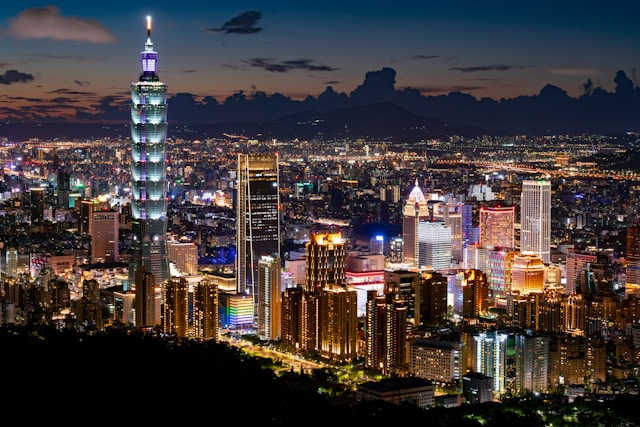


Photo by <a href="https://unsplash.com/@magict1911?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Timo Volz</a> on <a href="https://unsplash.com/photos/city-skyline-during-night-time-phjpsNFw6pM?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Unsplash</a>
  

#**Table of Contents**
* Executive Summary (BLUF)
* Business Problem
* Metrics
* Libraries
* Data
* Data Preprocessing
* Holdout Sample & Scaling
* Feature Importance
* Base Learners on Holdout Sample
* Ensembles & Deep Learning on Holdout Sample
* Learning Curves (Cross Validation)
* Winner Winner Chicken Dinner
* Keras Model Investigated
* Conclusion


#**Business Problem**
The real estate market in Taipei City is large, complex, and rapidly evolving. Factors like location, property features, nearby amenities, transportation options, school districts, and macroeconomic conditions all impact property valuations. Traditional methods of appraisal and pricing rely heavily on the expertise of human agents and appraisers. However, machine learning techniques have the potential to provide more accurate, data-driven valuations by analyzing large datasets of real estate transactions and property details.

Need
There is a growing demand from real estate companies, banks, investors, and home buyers/sellers in Taipei for better real estate evaluation models. Existing methods do not fully capture all relevant factors and are susceptible to human bias and error. By leveraging machine learning on large real estate datasets, companies can price properties more accurately, assess investment opportunities, manage risk, and make smarter real estate decisions overall.

#**Metrics**
MSE will be the primary aggregate performance metric as large errors are more important than smalletr prediction errors. MAE and $R^2$ will be reported as supplementary metrics. Over- and underprediction are deemed equally important, and the business problem calls for a ceiling on over- and underprediction of 20%. Accordingly, the worst instance prediction error will be presented.

#**var&bias tradeoff**
by optimizing features, produce the irreducable error for a certain data set
- high variance: overfitting causes a huge gap between validation error and training error (the model is not generally applicable)
- high bias: underfitting makes the validation error and training error more and more similar to each other as the data scale up


#**Libraries**


In [ ]:
# Basic libraries
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import unique
from numpy import where
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import pyplot
import scipy.stats as ss
import math

In [ ]:
# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold

In [ ]:
!pip install xgboost
!pip install keras==2.12.0 # You will have to restart the runtime after this install
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.


In [ ]:
from xgboost import XGBRegressor

In [ ]:
# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error

#**Data**
The following is adaptedfrom https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set

The market historical data set of real estate valuation were collected from Sindian Dist., New Taipei City, Taiwan.

Original attribute information:

The predictors/deatires are as follows:
- X1=the transaction date (for example, 2013.250=2013 March, 2013.500=2013 June, etc.)
- X2=the house age (unit: year)
- X3=the distance to the nearest MRT station (unit: meter)
- X4=the number of convenience stores in the living circle on foot (integer)
- X5=the geographic coordinate, latitude. (unit: degree)
- X6=the geographic coordinate, longitude. (unit: degree)

The target is as follows:
Y= house price of unit area (10000 New Taiwan Dollar/Ping, where Ping is a local unit, 1 Ping = 3.3 meter squared)

In [ ]:
# Update openpyxl
!pip install --upgrade openpyxl


In [ ]:
# Read data from UCI Machine Learning Repo
file_ = "https://archive.ics.uci.edu/ml/machine-learning-databases/00477/Real%20estate%20valuation%20data%20set.xlsx"
df = pd.DataFrame(pd.read_excel(file_)) # read in csv file

In [ ]:
# Head of df
df.head(10)

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1
5,6,2012.666667,7.1,2175.03000,3,24.96305,121.51254,32.1
6,7,2012.666667,34.5,623.47310,7,24.97933,121.53642,40.3
7,8,2013.416667,20.3,287.60250,6,24.98042,121.54228,46.7
8,9,2013.500000,31.7,5512.03800,1,24.95095,121.48458,18.8
9,10,2013.416667,17.9,1783.18000,3,24.96731,121.51486,22.1


#**Data Preprocessing**

In [ ]:
# Drop the index column (Column 0, "No")
if 'No' in df.columns:
  df = df.drop(["No"], axis = 1)

# The column names are verbose, so rename them (optional)
df.rename(columns = {"X1 transaction date": "X1_Date", "X2 house age": "X2_Age", "X3 distance to the nearest MRT station": "X3_MRT", "X4 number of convenience stores": "X4_Stores", "X5 latitude": "X5_Lat", "X6 longitude": "X6_Long", "Y house price of unit area": "Y_Price"},inplace = True)

# Examine the data using df.head() or df.tail()
print("HEAD of df\n", df.head())

HEAD of df
        X1_Date  X2_Age     X3_MRT  X4_Stores    X5_Lat    X6_Long  Y_Price
0  2012.916667    32.0   84.87882         10  24.98298  121.54024     37.9
1  2012.916667    19.5  306.59470          9  24.98034  121.53951     42.2
2  2013.583333    13.3  561.98450          5  24.98746  121.54391     47.3
3  2013.500000    13.3  561.98450          5  24.98746  121.54391     54.8
4  2012.833333     5.0  390.56840          5  24.97937  121.54245     43.1


In [ ]:
# Split Predictors & Target
X = pd.DataFrame(df.drop(['Y_Price'],axis=1))
y = pd.DataFrame(df['Y_Price'])
y.columns = ['Y_Price']
print('X:\n',X.head())
print('\ny\n',y.head())

X:
        X1_Date  X2_Age     X3_MRT  X4_Stores    X5_Lat    X6_Long
0  2012.916667    32.0   84.87882         10  24.98298  121.54024
1  2012.916667    19.5  306.59470          9  24.98034  121.53951
2  2013.583333    13.3  561.98450          5  24.98746  121.54391
3  2013.500000    13.3  561.98450          5  24.98746  121.54391
4  2012.833333     5.0  390.56840          5  24.97937  121.54245

y
    Y_Price
0     37.9
1     42.2
2     47.3
3     54.8
4     43.1


In [ ]:
# Check skewness of target
y.skew(axis = 0, skipna = True)

Y_Price    0.599853
dtype: float64

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='X5_Lat', ylabel='X6_Long'>

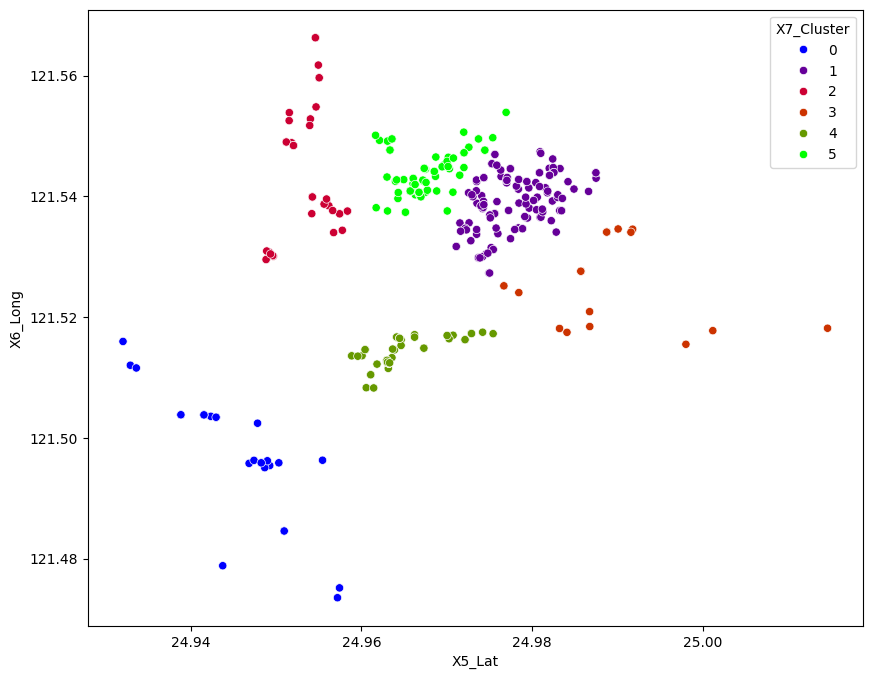

In [ ]:
# k-means clustering of latitudes & longitudes
# define the model
model = KMeans(n_clusters=6)
# fit the model
model.fit(X[['X5_Lat','X6_Long']])
# assign a cluster to each example
yhat = pd.DataFrame(model.predict(X[['X5_Lat','X6_Long']]),columns=['X7_Cluster'])
if 'X7_Cluster' not in X:
  X = pd.concat([X,yhat],axis=1)
else:
  X['X7_Cluster'] = yhat
colors = ['#747FE3', '#8EE35D', '#E37346']
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(10,8))
sns.scatterplot(x='X5_Lat', y='X6_Long', data=X, hue='X7_Cluster', palette = "brg")


In [ ]:
# Tukey Rule outliers for target (price/ping)
def tukey_rule(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_lim = data[col].quantile(0.5) + 2 * IQR
    lower_lim = data[col].quantile(0.5) - 2 * IQR
    outliers = []
    for index, x in enumerate(data[col]):
        if x < lower_lim or x >= upper_lim:
            outliers.append(index)
    return outliers

# # Identify outliers
print('OUTLIERS:\n)')
col = 'Y_Price'
outliers_Tukey = tukey_rule(y,col)
print("Column ",col,": ",outliers_Tukey)
X = X.drop(labels=outliers_Tukey, axis=0)
y = y.drop(labels=outliers_Tukey, axis=0)


OUTLIERS:
)
Column  Y_Price :  [220, 270, 312]


<Axes: xlabel='Y_Price'>

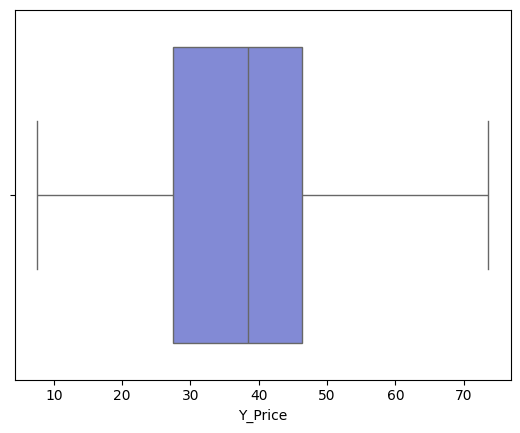

In [ ]:
# Boxplot y to check outliers
sns.boxplot(x=y['Y_Price'])

Data leakage is a phenomenon that occurs when information from the dataset intended to be used for model testing or validation is inadvertently used during the training process. This can lead to overly optimistic performance estimates and models that fail to generalize well to new, unseen data.

In the case of the Taipei City real estate dataset from the UCI Machine Learning Repository, there is a potential for data leakage due to the inclusion of the transaction date (X1) as a predictor variable. The transaction date could inadvertently encode information about the house price, which is the target variable we are trying to predict.

Here's how data leakage could occur in this dataset:

The dataset is sorted or grouped by transaction date before splitting into training and test sets.

Since house prices tend to change over time due to market conditions, houses sold in a particular time period may have similar prices.

If the training and test sets contain houses from distinct time periods, the model could learn to associate the transaction date with the corresponding price range.

During evaluation on the test set, the model would appear to perform well simply because it has learned the mapping between transaction date and price, rather than generalizing based on the other predictor variables.

To combat data leakage from the transaction date variable, several techniques can be employed:

- Remove Transaction Date: The simplest solution is to remove the transaction date variable entirely from the dataset before training the model.
- Engineer New Features: Instead of using the raw transaction date, create new features that represent the temporal trends but do not directly leak information. For example, compute the number of months/years since the first or last transaction in the dataset.
- Train/Test Split by Time: Split the dataset into training and test sets based on time periods, ensuring that the training set comprises only transactions before a certain date, while the test set contains transactions after that date. This simulates a realistic scenario where the model is trained on past data to predict future prices.
- Cross-Validation: Use techniques like forward chaining or cross-validation with time-based splits to evaluate the model's performance on future data while utilizing all available data for training.
- Monitor Performance Drift: Even after taking precautions, monitor the model's performance on new data over time. If the performance degrades significantly, it may indicate that the model has learned spurious correlations or that the underlying data distribution has shifted, requiring retraining or adjustments.

#**Holdout Sample & Scaling**

In [ ]:
col_names = X.columns

In [ ]:
# Create holdout sample
# Note: split before doing any trasformations on the data!!!

X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
                     test_size=0.2,    # 80-20 training vs test set split
                     random_state=0)
print('Shape of X and y',X.shape, y.shape, '\nShape of training set X and y',X_train.shape, y_train.shape, '\nShape of test set X and y',X_test.shape, y_test.shape)


Shape of X and y (411, 7) (411, 1) 
Shape of training set X and y (328, 7) (328, 1) 
Shape of test set X and y (83, 7) (83, 1)


In [ ]:
# Bringing features onto the same scale：normalization and standardization:

# Min-max scaling(Normalization) (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

# mms = MinMaxScaler()
# X_norm = mms.fit_transform(X)

# Standardization z-score  (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
# from sklearn.preprocessing import StandardScaler
stdsc1 = StandardScaler()
X_train_std = stdsc1.fit_transform(X_train)
X_test_std = stdsc1.transform(X_test)
stdsc2 = StandardScaler()
y_train_std = stdsc2.fit_transform(y_train)
y_test_std = stdsc2.transform(y_test)

#**Feature Importance**


<ipython-input-18-29da384aea37>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_std, y_train_std)                  # Fit the RandomForest instance using the traiing data


<BarContainer object of 7 artists>

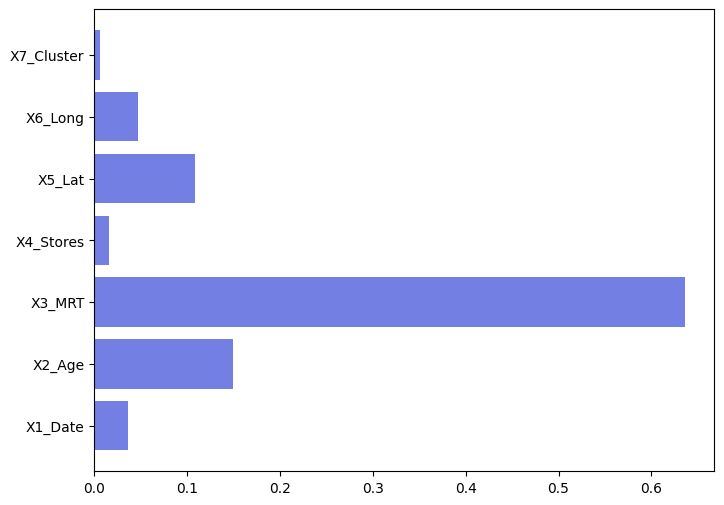

In [ ]:
# Feature Importance
# Code adapted from this source: https://machinelearningmastery.com/calculate-feature-importance-with-python/
# Let's try to weed out the really poor predictors
from matplotlib import pyplot                            # Import pyplot (to be able generate the barchart later in this snippet)
plt.rcParams["figure.figsize"] = (8,6)
model = RandomForestRegressor()                         # Create an instance of a RandomForestClassifier
# fit the model
model.fit(X_train_std, y_train_std)                  # Fit the RandomForest instance using the traiing data
# get importance
importance = model.feature_importances_                  # The RandomForestClassifier instance computes feature importance as a bonus. Store them imprtance values in importance'.
# summarize feature importance
plt.barh(col_names, model.feature_importances_)

#**Base Learner Regressors on Holdout Sample**

In [ ]:
# Report performance
def Performance(actuals,predictions):
  print('MSE: %.2f ' % mean_squared_error(actuals, predictions))
  print('MAE: %.2f ' % mean_absolute_error(actuals,predictions))
  print('R^2: %.2f' % r2_score(actuals, predictions))

# Plotting the actuals vs predictions
def PredsVsActuals(actuals,predictions):
  plt.plot(actuals, predictions, '.', color='blue')
  plt.xlabel('Actuals')
  plt.ylabel('Predictions')
  plt.show()

REGRESSOR:  Multiple Linear Regression 

Coefficients: 
 [ 0.10404294 -0.26608511 -0.47533117  0.26340291  0.18974624 -0.01597636
 -0.19147538]
MSE: 51.59 
MAE: 5.44 
R^2: 0.61


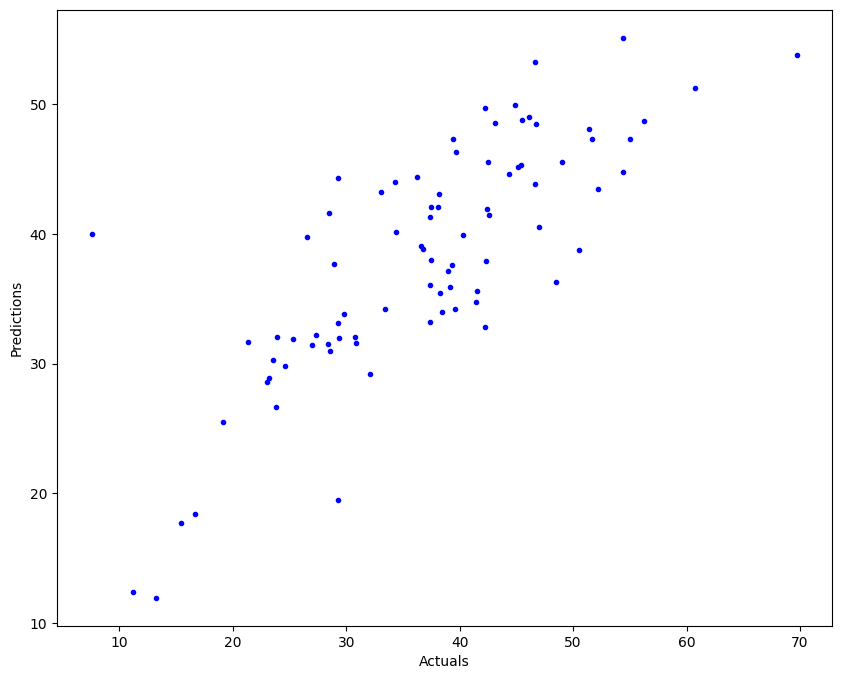

Maximum error:  425.942250283563 %


REGRESSOR:  Lasso Regression 

Coefficients: 
 [ 0.         -0.         -0.21056237  0.          0.          0.
 -0.        ]
MSE: 101.54 
MAE: 7.71 
R^2: 0.23


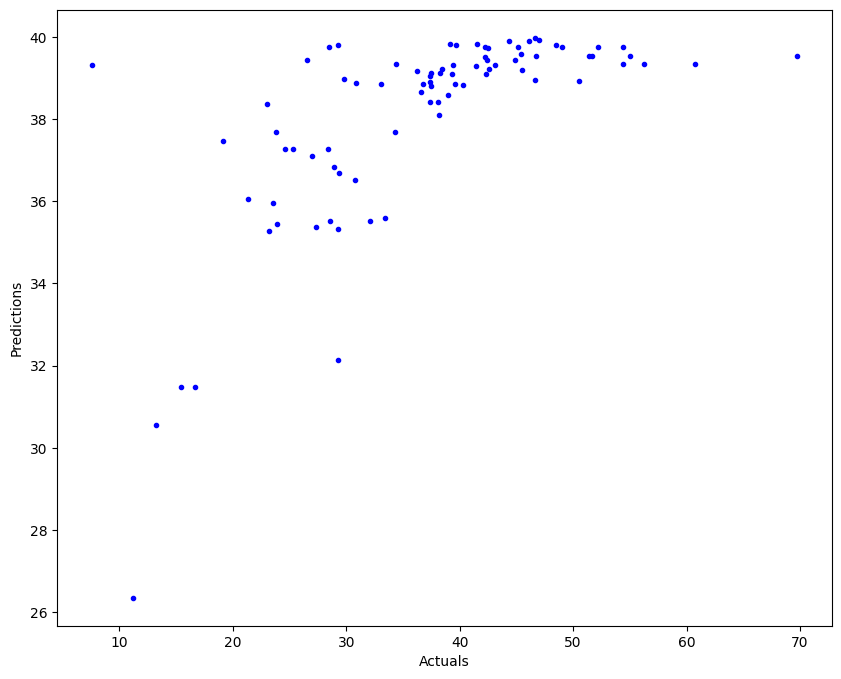

Maximum error:  417.3498754265299 %


REGRESSOR:  Ridge Regression 

Coefficients: 
 [ 0.10381237 -0.26561936 -0.47270976  0.26362689  0.19014376 -0.014189
 -0.19091294]
MSE: 51.57 
MAE: 5.44 
R^2: 0.61


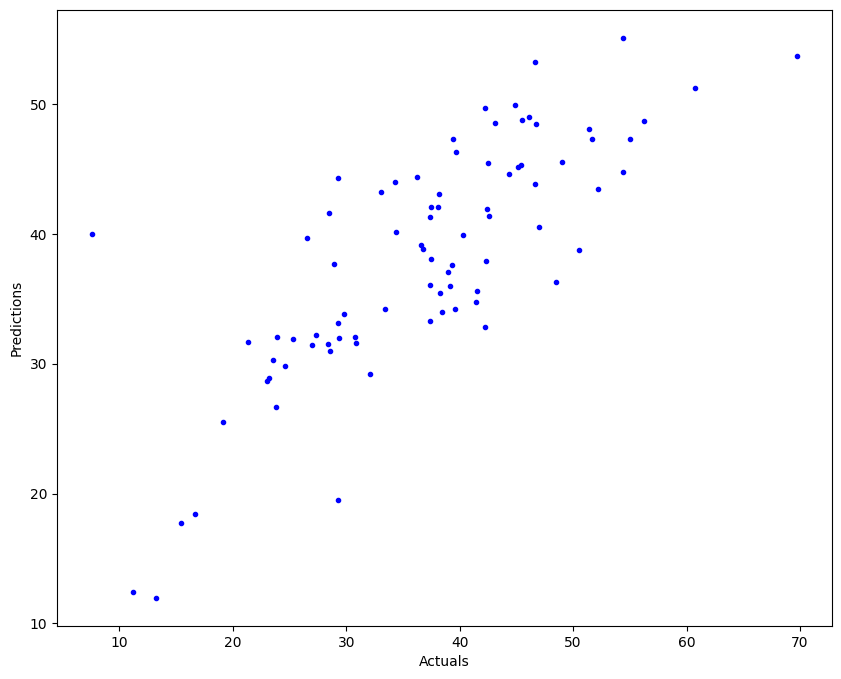

Maximum error:  425.8724560249296 %


REGRESSOR:  ElasticNet Regression 

Coefficients: 
 [ 0.         -0.11504476 -0.31848072  0.20500899  0.15180034  0.00607517
 -0.01275866]
MSE: 61.39 
MAE: 5.95 
R^2: 0.53


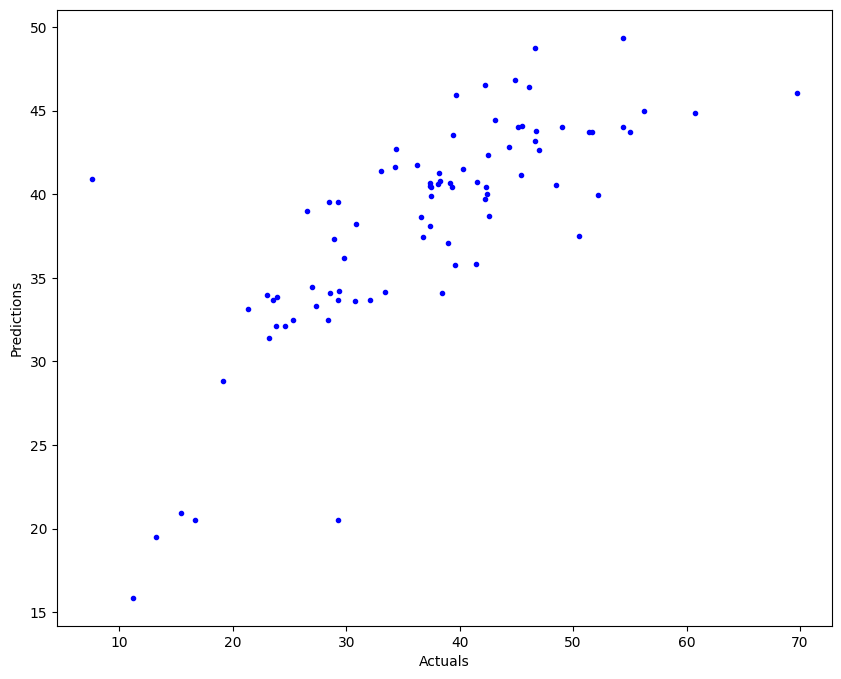

Maximum error:  437.940958299904 %


REGRESSOR:  kNN 

MSE: 48.28 
MAE: 5.08 
R^2: 0.63


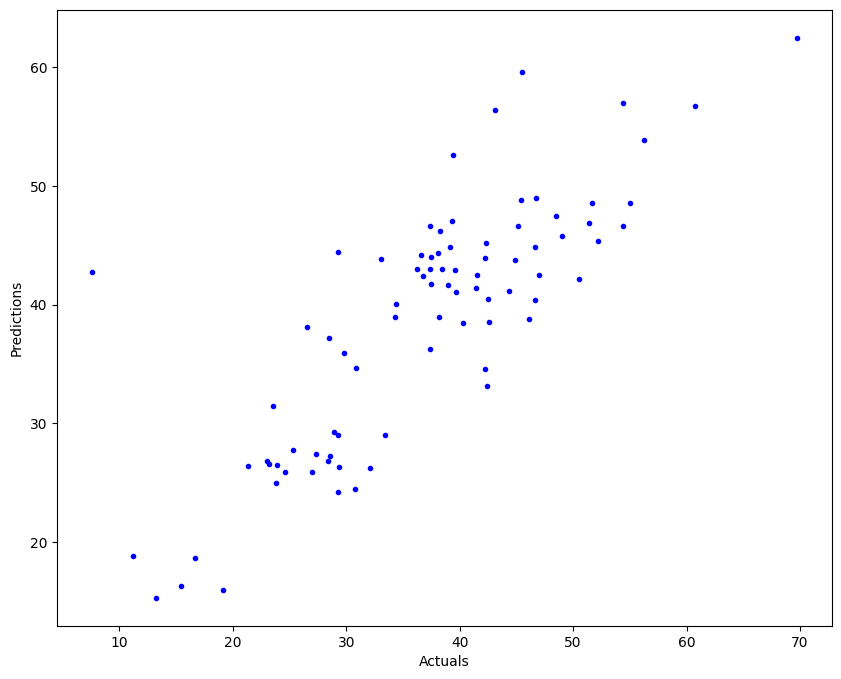

Maximum error:  462.8947368421053 %


REGRESSOR:  SVR 

MSE: 49.79 
MAE: 4.98 
R^2: 0.62


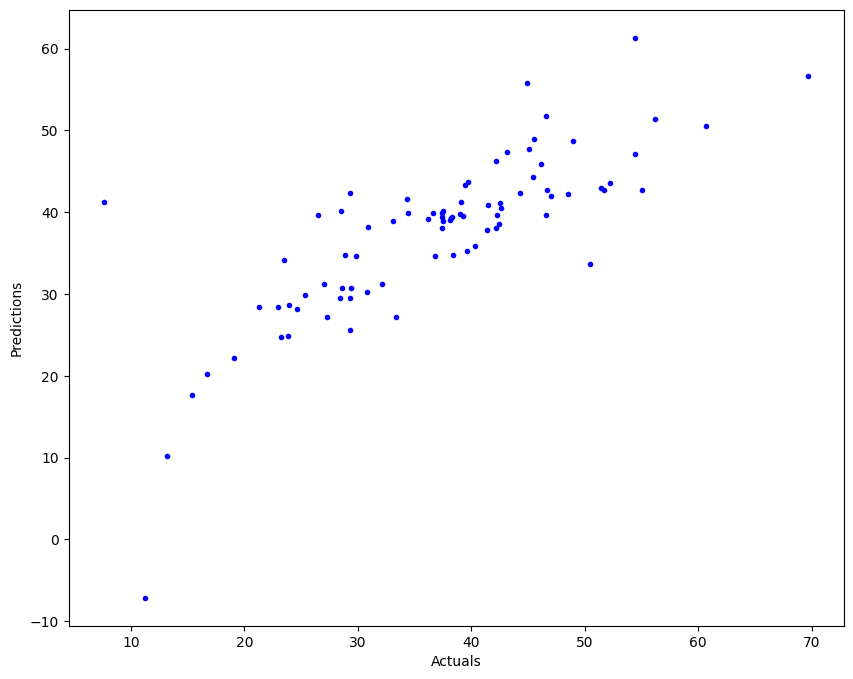

Maximum error:  443.020193718558 %


REGRESSOR:  Decision Tree 

MSE: 67.13 
MAE: 5.88 
R^2: 0.49


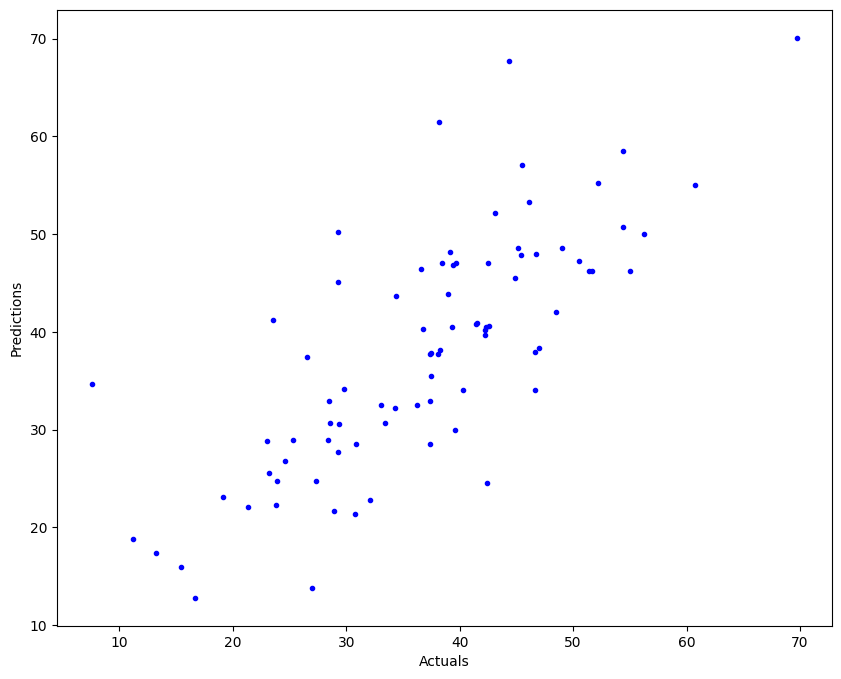

Maximum error:  356.5789473684211 %


REGRESSOR:  Multilayer Perceptron 



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MSE: 55.45 
MAE: 5.25 
R^2: 0.58


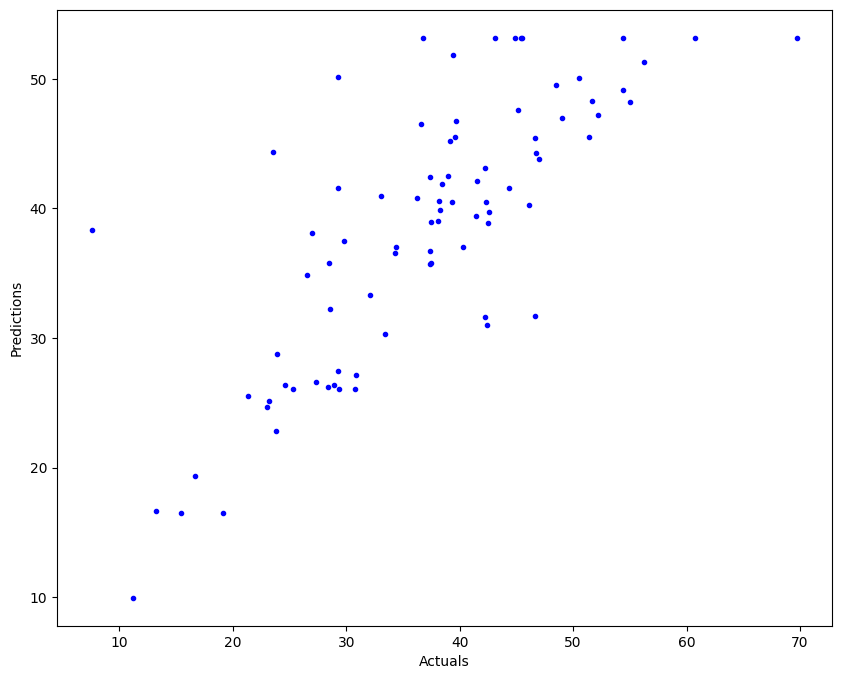

Maximum error:  403.8964227313204 %




In [ ]:
# Loop through base learners
names = ['Multiple Linear Regression', 'Lasso Regression', 'Ridge Regression','ElasticNet Regression','kNN', 'SVR','Decision Tree','Multilayer Perceptron']
regressors = [linear_model.LinearRegression(),
              Lasso(alpha=0.5),
              Ridge(alpha=0.5),
              ElasticNet(alpha=0.25, l1_ratio=0.5),
              KNeighborsRegressor(n_neighbors=5),
              SVR(kernel = 'poly'),   #Can try kernels 'poly', 'linear' and 'sigmoid' kernels
              DecisionTreeRegressor(),
              MLPRegressor(hidden_layer_sizes=(150,150,1),
                       max_iter = 300,activation = 'relu',
                       solver = 'adam')]

for name, regr in zip(names, regressors):
  print('REGRESSOR: ',name,'\n')
  regr.fit(X_train_std, np.ravel(y_train_std))
  # Make predictions
  y_pred_std = regr.predict(X_test_std)
  y_pred_std = pd.DataFrame(y_pred_std)
  y_pred = stdsc2.inverse_transform(y_pred_std)
  if name in ['Multiple Linear Regression', 'Lasso Regression', 'Ridge Regression','ElasticNet Regression']:
      print('Coefficients: \n', regr.coef_)
  # Performance
  plt.figure(figsize=(10,8))
  Performance(y_test,y_pred)
  PredsVsActuals(y_test,y_pred)
  # Worst-case instance prediction
  y_pred = pd.DataFrame(y_pred)
  results = pd.concat([y_pred, y_test.set_index(y_pred.index)], axis=1)
  results.columns=['Pred','Act']
  results['error'] = (results.Pred - results.Act)/results.Act
  print('Maximum error: ',100*np.max(results.error),'%\n\n')

#**Ensembles & Deep Learning on Holdout Sample**

In [ ]:
# Stacked Ensemble
# Code in this snippet adapted from https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

# get a stacking ensemble of models
def get_stacking():
  # define the base models
  level0 = list()
  level0.append(('MLR', linear_model.LinearRegression()))
  level0.append(('Ridge', Ridge(alpha=0.5)))
  level0.append(('RF', RandomForestRegressor()))
  level0.append(('XGB', XGBRegressor(objective ='reg:squarederror')))
  # define meta learner model
  level1 = linear_model.LinearRegression()
  # define the stacking ensemble
  model = StackingRegressor(estimators=level0, final_estimator=level1, cv=10)
  return model

# get a list of models to evaluate
def get_models():
  models = dict()
  models['Multiple Linear Regression'] = linear_model.LinearRegression()
  models['Ridge Regression'] = Ridge(alpha=0.5)
  models['Random Forest'] = RandomForestRegressor()
  models['XGBoost'] = XGBRegressor(objective ='reg:squarederror')
  models['Stacked Ensemble'] = get_stacking()
  return models

In [ ]:
# Keras Deep Learning model definition
def BuildModel():
 model = Sequential()
 model.add(Dense(50, input_dim=7,activation='relu'))
 model.add(Dense(50, activation='relu'))
 model.add(Dense(1,activation='linear'))
 model.compile(loss="mean_squared_error", optimizer="adam")
 return model

REGRESSOR:  Random Forest 



<ipython-input-23-2bec75791221>:6: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  KerasRegressor(build_fn=BuildModel,nb_epoch=500,epochs=500, batch_size=20,verbose=0),


MSE: 36.61 
MAE: 4.35 
R^2: 0.72


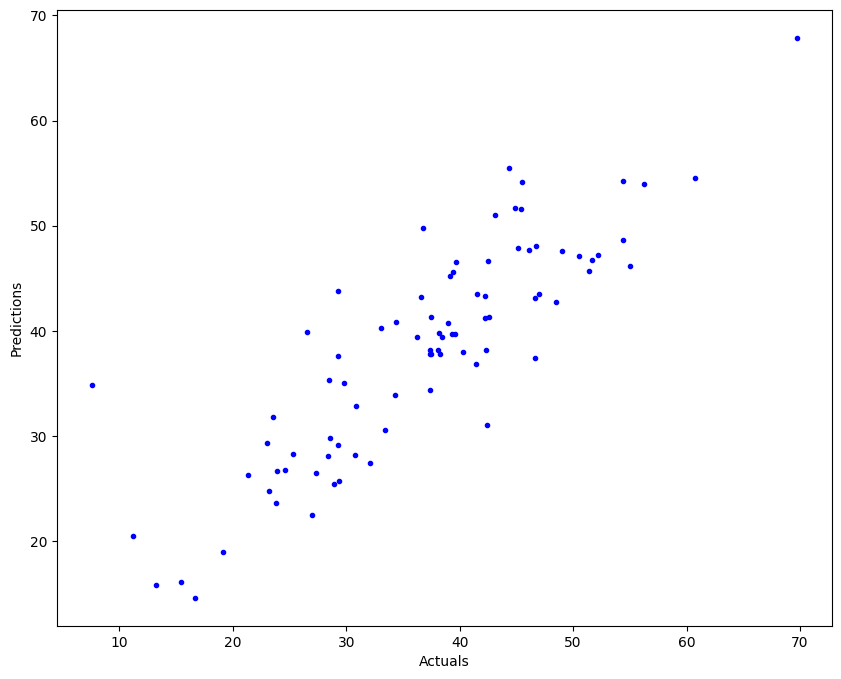

Maximum error:  358.98026315789485 %


REGRESSOR:  XGBoost 

MSE: 45.92 
MAE: 4.98 
R^2: 0.65


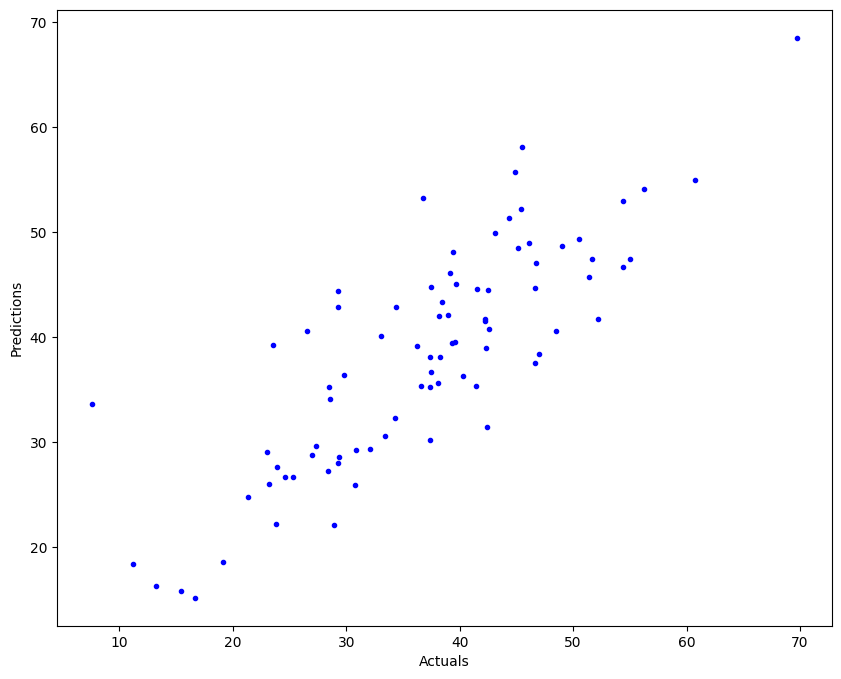

Maximum error:  343.3344790810033 %


REGRESSOR:  AdaBoost 

MSE: 44.09 
MAE: 4.87 
R^2: 0.66


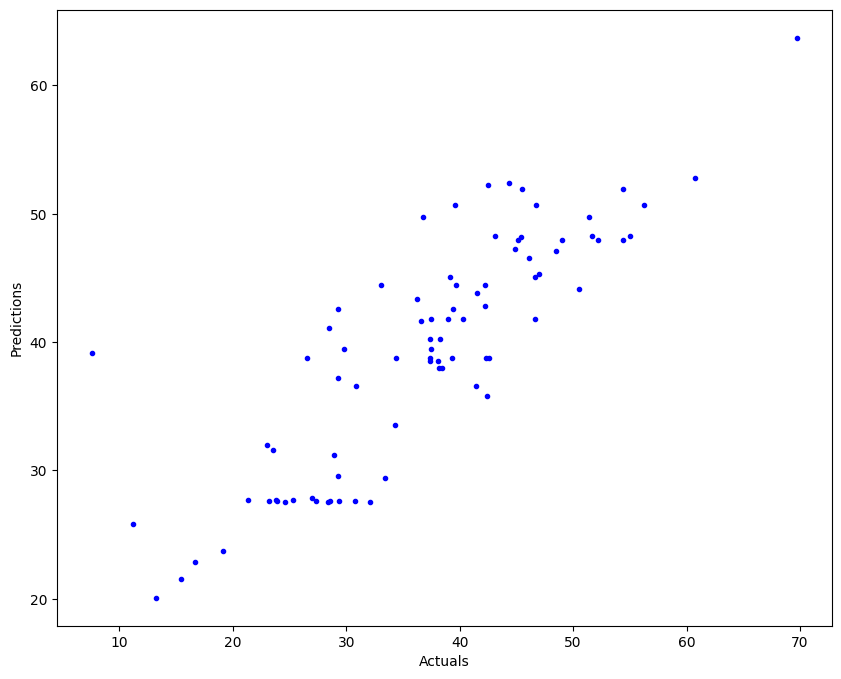

Maximum error:  414.81136469492316 %


REGRESSOR:  Keras Deep Learning 

MSE: 68.73 
MAE: 6.07 
R^2: 0.48


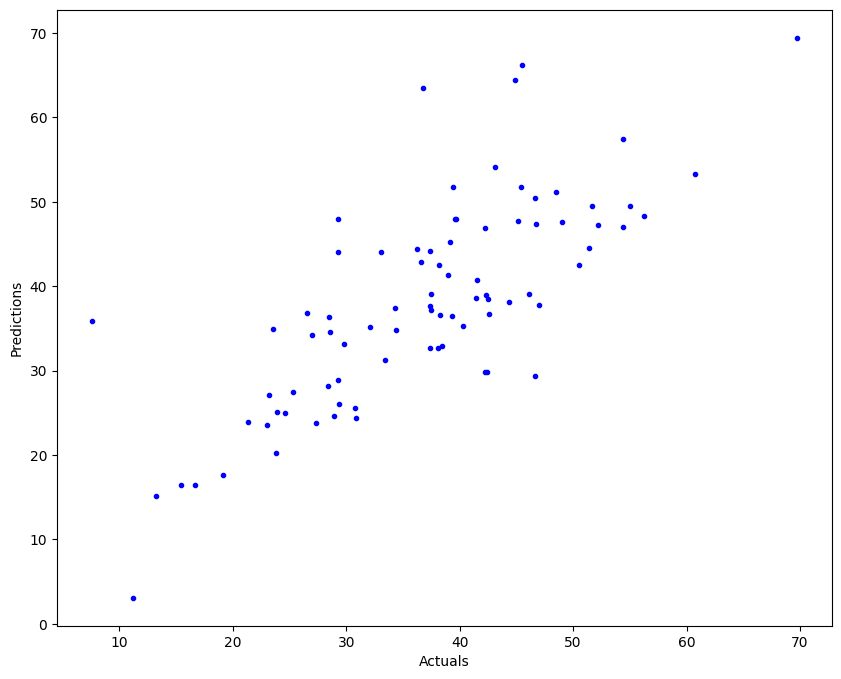

Maximum error:  372.3392787732576 %


REGRESSOR:  Stacked Ensemble 

MSE: 35.06 
MAE: 4.29 
R^2: 0.73


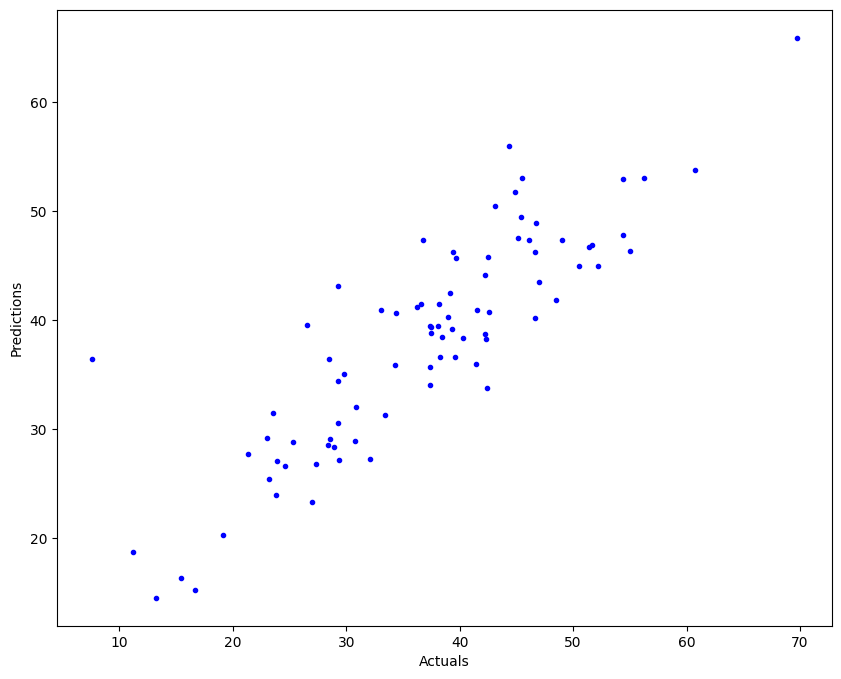

Maximum error:  379.37123189917696 %




In [ ]:
# Loop through ensembles and deep learning model
names = ['Random Forest', 'XGBoost', 'AdaBoost','Keras Deep Learning','Stacked Ensemble']
regressors = [RandomForestRegressor(),
              XGBRegressor(objective ='reg:squarederror'),
              AdaBoostRegressor(),
              KerasRegressor(build_fn=BuildModel,nb_epoch=500,epochs=500, batch_size=20,verbose=0),
              get_stacking()
              ]

for name, regr in zip(names, regressors):
  print('REGRESSOR: ',name,'\n')
  regr.fit(X_train_std, np.ravel(y_train_std))
  # Make predictions
  y_pred_std = regr.predict(X_test_std)
  y_pred_std = pd.DataFrame(y_pred_std)
  y_pred = stdsc2.inverse_transform(y_pred_std)
  # Performance
  plt.figure(figsize=(10,8))
  Performance(y_test,y_pred)
  PredsVsActuals(y_test,y_pred)
  # Worst-case instance prediction
  y_pred = pd.DataFrame(y_pred)
  y_test = pd.DataFrame(y_test)
  results = pd.concat([y_pred, y_test.set_index(y_pred.index)], axis=1)
  results.columns=['Pred','Act']
  results['error'] = (results.Pred - results.Act)/results.Act
  print('Maximum error: ',100*np.max(results.error),'%\n\n')

## Bias-Variance Tradeoff

The bias-variance tradeoff is a fundamental concept in machine learning that describes the relationship between a model's ability to accurately capture the underlying patterns in the data (bias) and its tendency to overfit or generalize poorly to new, unseen data (variance). Understanding this tradeoff is crucial for building effective machine learning models, including those used for real estate valuation tasks like the Taipei City dataset.

Bias
Bias refers to the systematic errors or assumptions made by a model that cause it to consistently miss or deviate from the true underlying relationship between the input features and the target variable. A model with high bias oversimplifies the data and fails to capture important patterns, resulting in underfitting and poor performance on both the training and test data.

In the context of the Taipei City real estate dataset, a high-bias model might make overly simplistic assumptions about the relationship between factors like location, property age, and amenities, and the housing prices. For example, a linear regression model may not be able to accurately capture the complex, non-linear relationships between these variables and property values.

Variance
Variance, on the other hand, refers to the model's sensitivity to fluctuations or noise in the training data. A model with high variance is overly complex and flexible, allowing it to fit the training data extremely well, including the noise and outliers. However, this can lead to overfitting, where the model fails to generalize well to new, unseen data.

For the real estate valuation task, a high-variance model might be overly influenced by specific data points or outliers in the training set, leading it to learn patterns that are not representative of the overall population. For example, a highly complex neural network with too many parameters and layers might memorize the training data, including any anomalies or errors, instead of learning the genuine underlying patterns.

The Tradeoff
The bias-variance tradeoff arises because reducing bias (by increasing model complexity) often leads to an increase in variance, and vice versa. A model with low bias and high variance will overfit the training data, while a model with high bias and low variance will underfit, failing to capture the true underlying patterns.

The goal in machine learning is to find the optimal balance between bias and variance, where the model is complex enough to capture the relevant patterns in the data (low bias) but not so complex that it overfits and fails to generalize (low variance).

Techniques to Address the Tradeoff
Several techniques can be employed to navigate the bias-variance tradeoff effectively:

- Model Selection: Choose an appropriate model complexity based on the characteristics of the data and the problem. For example, linear models may be suitable for simpler problems, while neural networks or ensemble methods may be better suited for more complex, non-linear relationships.
- Regularization: Techniques like L1 (Lasso) or L2 (Ridge) regularization can be used to introduce a penalty term that constrains the model's complexity, reducing overfitting and controlling variance.
- Cross-Validation: Use cross-validation techniques, such as k-fold cross-validation, to estimate the model's performance on unseen data and tune hyperparameters to find the optimal balance between bias and variance.
- Ensemble Methods: Combine multiple models, such as decision trees or neural networks, using techniques like bagging (random forests) or boosting (gradient boosting machines). Ensemble methods can often achieve lower bias and variance by leveraging the strengths of individual models.
- Feature Engineering: Carefully select and engineer relevant features that capture the most important patterns in the data, reducing the need for overly complex models and mitigating bias.

By understanding the bias-variance tradeoff and employing appropriate techniques, machine learning models for real estate valuation, like those applied to the Taipei City dataset, can achieve better performance, generalization, and robustness, leading to more reliable and accurate property price predictions.

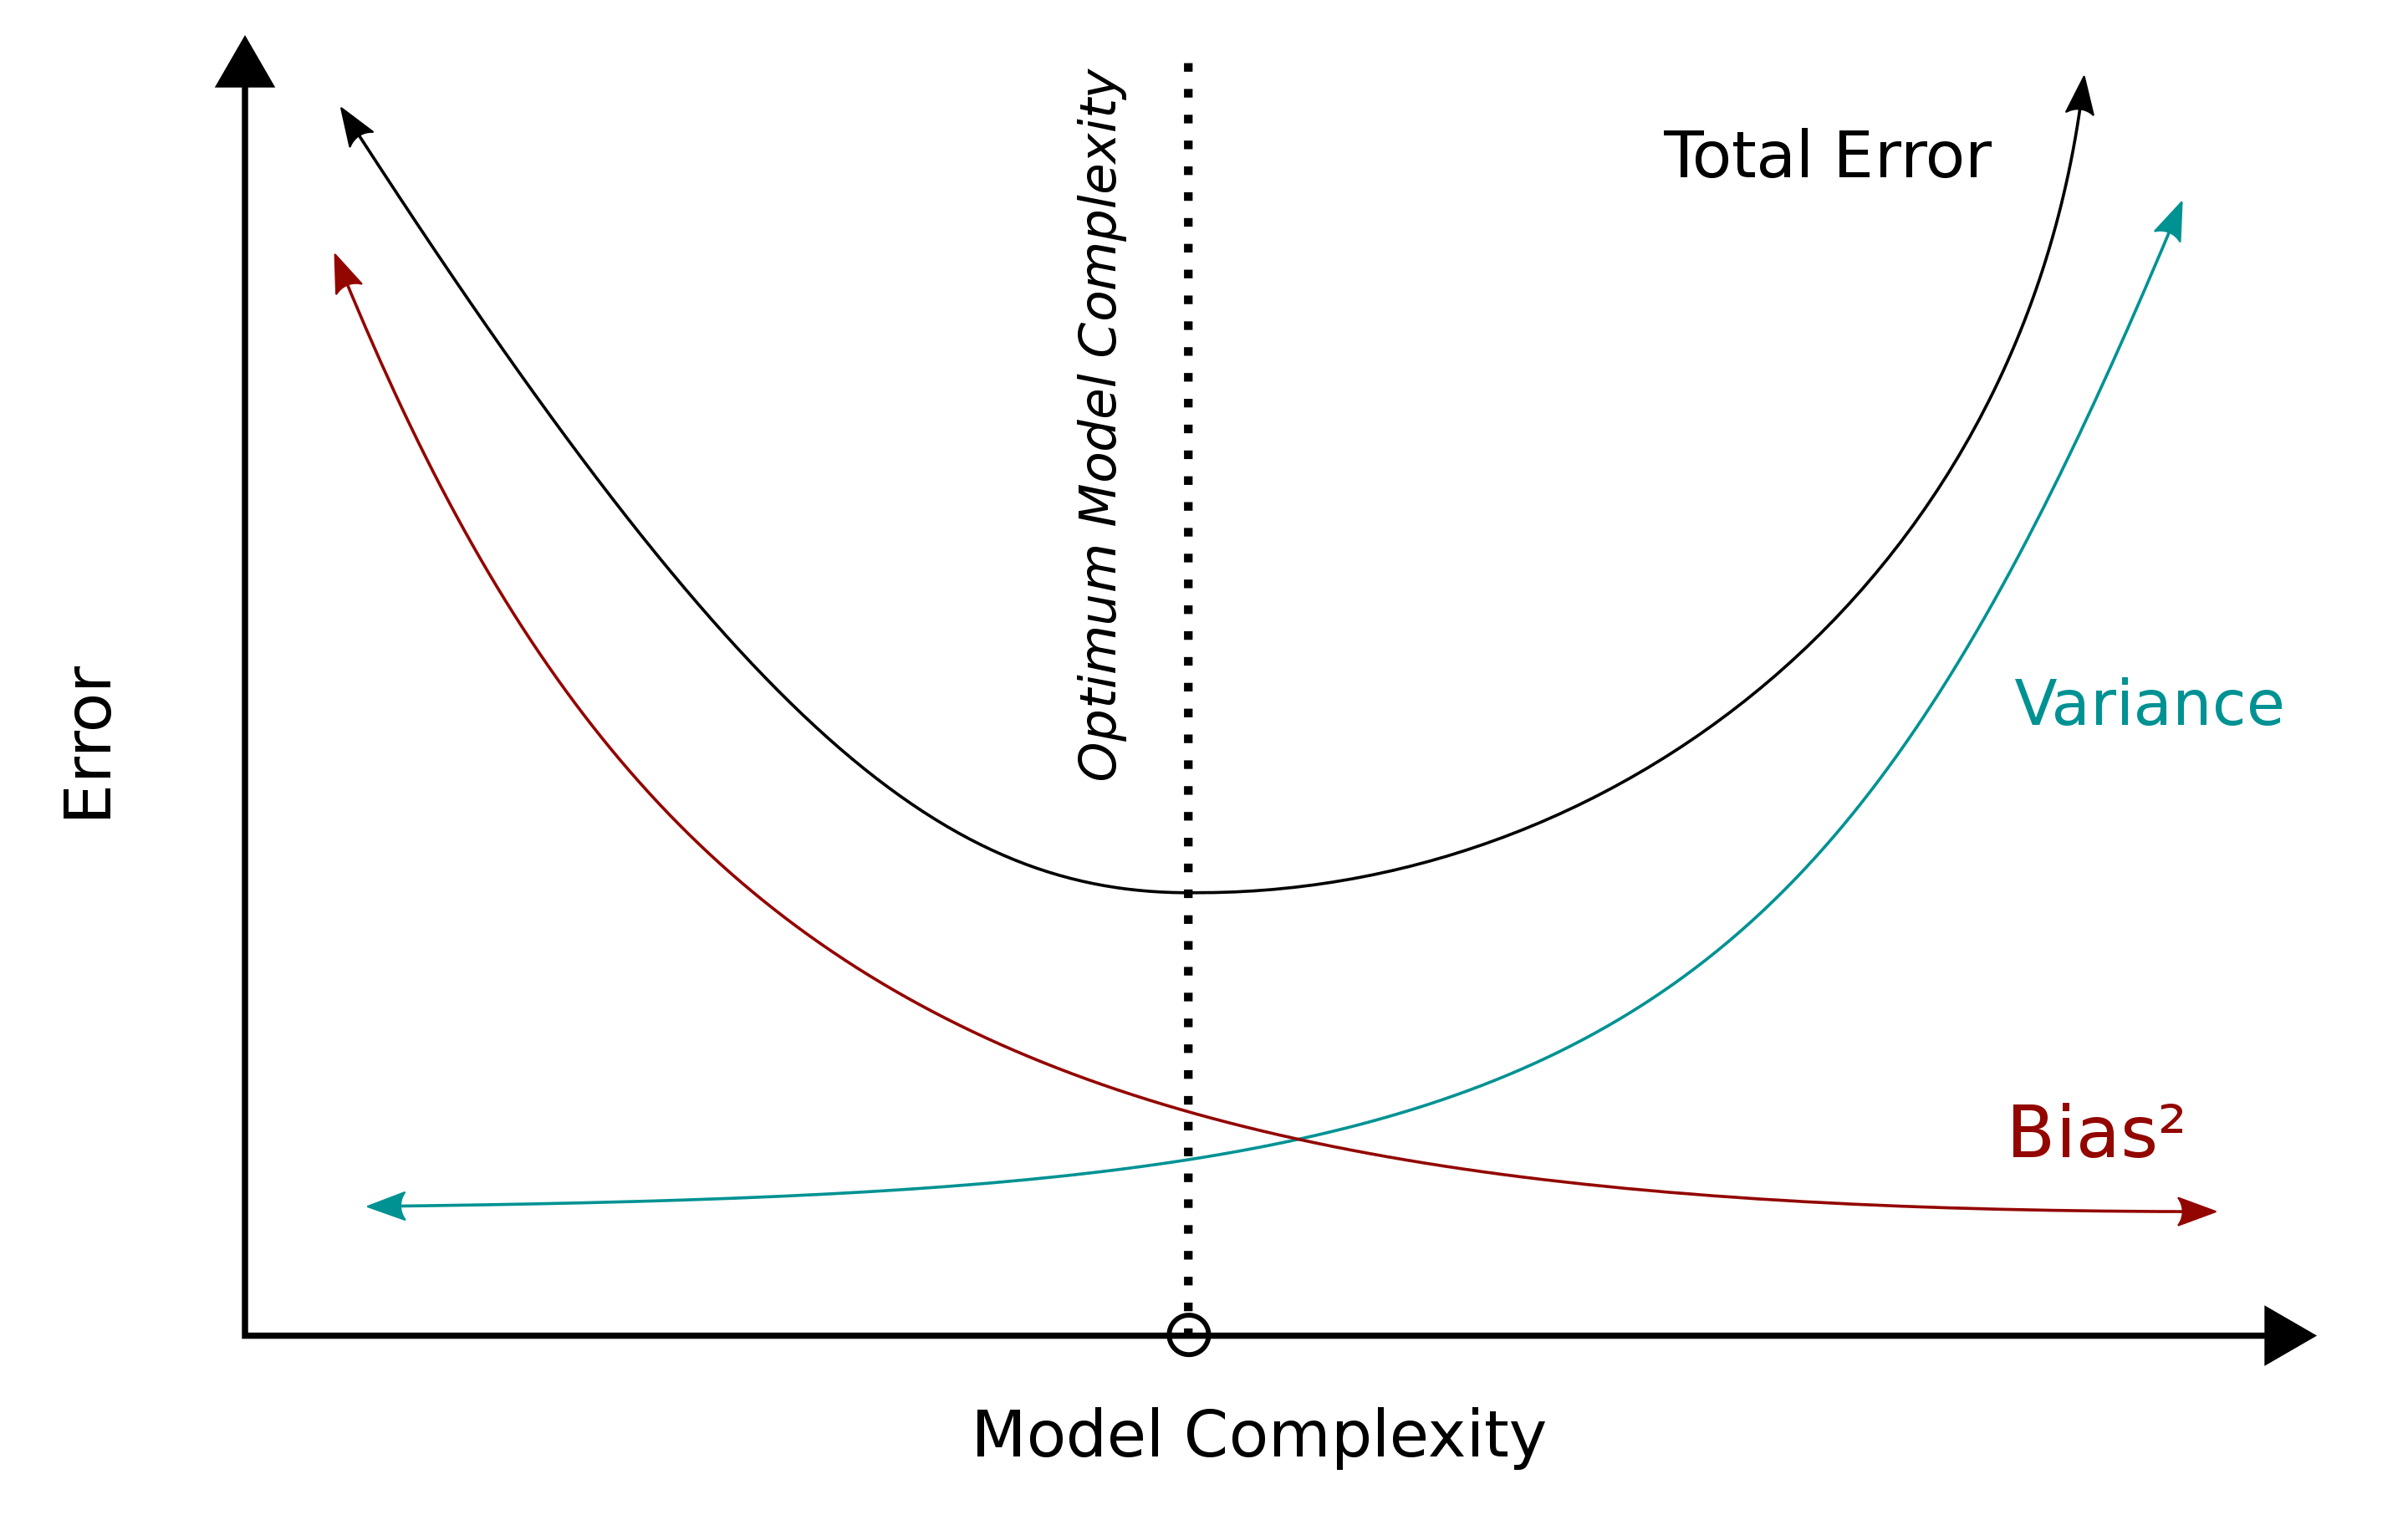

## Learning Curves

Learning Curves
Learning curves are an important tool in machine learning for diagnosing the performance of a model and understanding the bias-variance tradeoff. They provide insights into whether a model is underfitting or overfitting the data, and can guide decisions on how to improve the model's performance.

What are Learning Curves?
Learning curves are plots that show the model's performance on the training and validation (or test) datasets as a function of the training set size. The performance metric used (e.g., mean squared error, accuracy, etc.) is plotted on the y-axis, while the x-axis represents the number of training examples.

Typically, two curves are plotted:

Training Curve: Represents the model's performance on the training data as the training set size increases.
Validation/Test Curve: Represents the model's performance on the validation or test data as the training set size increases.
Interpreting Learning Curves
By analyzing the shape and behavior of the learning curves, we can diagnose potential issues with the model's performance and gain insights into the bias-variance tradeoff.

High Bias (Underfitting)
If both the training and validation curves have high error rates, and the gap between them is relatively small, it indicates that the model is underfitting the data due to high bias. In this case, the model is too simple to capture the underlying patterns in the data, and adding more training data is unlikely to improve performance significantly.

High Variance (Overfitting)
If the training curve has a low error rate, but the validation curve has a high error rate, and the gap between the two curves is large, it suggests that the model is overfitting the data due to high variance. The model is too complex and is fitting the noise or outliers in the training data, failing to generalize well to new, unseen data.

Ideal Learning Curves
The ideal learning curves would have both the training and validation curves converging to a low error rate as the training set size increases. This indicates that the model is capturing the underlying patterns in the data without overfitting or underfitting.

Using Learning Curves
Learning curves can guide the next steps in improving a model's performance:

High Bias: If the model is underfitting, consider increasing the model's complexity (e.g., adding more features, increasing the depth of a decision tree, or using a more complex model like a neural network).
High Variance: If the model is overfitting, techniques like regularization, early stopping, or using simpler models can help reduce variance and improve generalization.
Sufficient Data: If both curves converge to a low error rate, it may indicate that the model has sufficient data and complexity to capture the underlying patterns, and further improvements may require more advanced techniques or feature engineering.

#**Learning Curves (Cross Validation) in code**

<ipython-input-24-290895ca0aa5>:56: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ['regressor', KerasRegressor(build_fn=BuildModel,nb_epoch=500,epochs=500, batch_size=20,verbose=0)]])


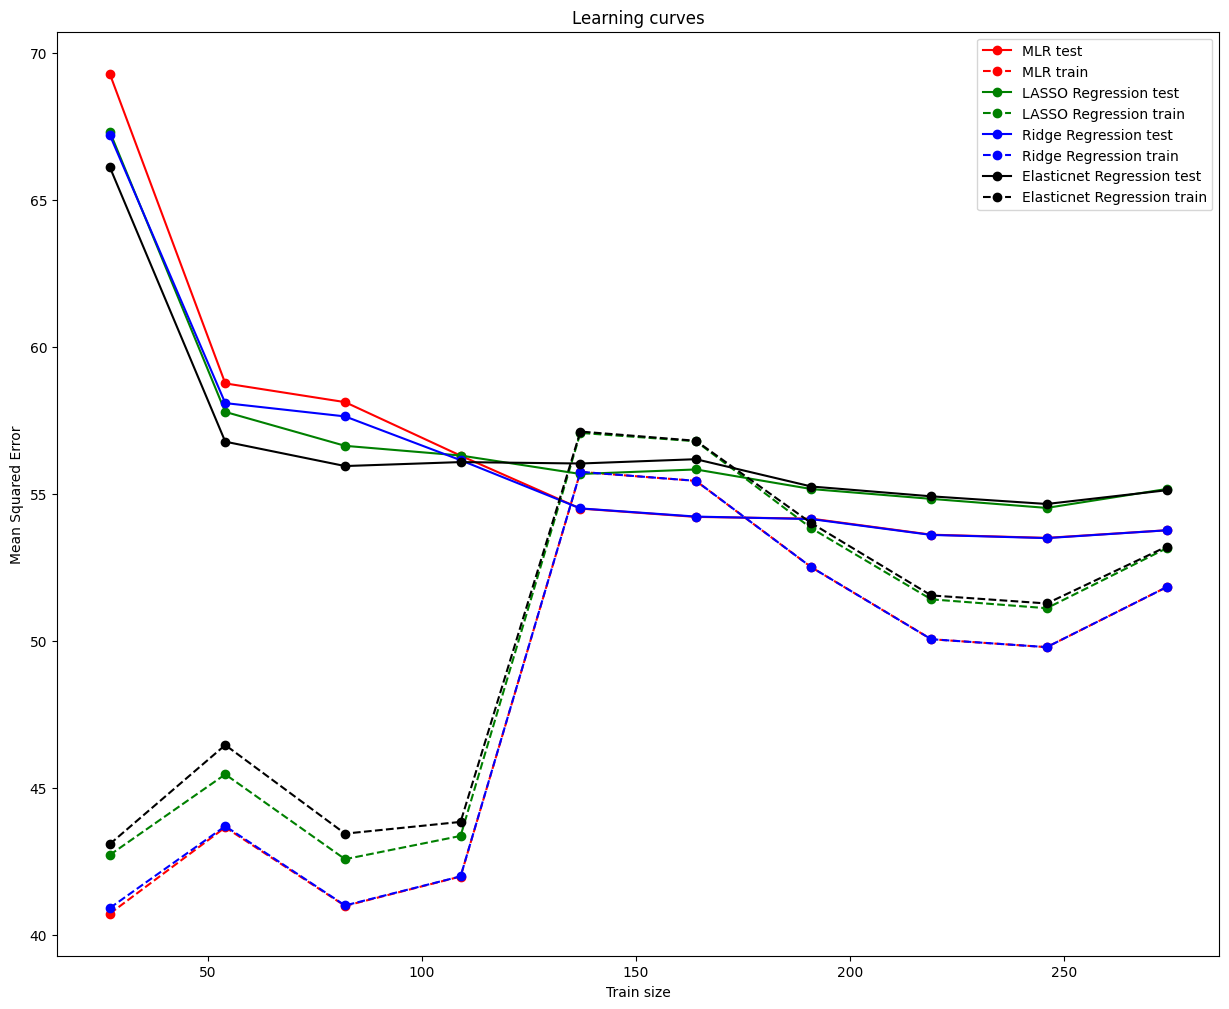

<Figure size 1600x1200 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perce

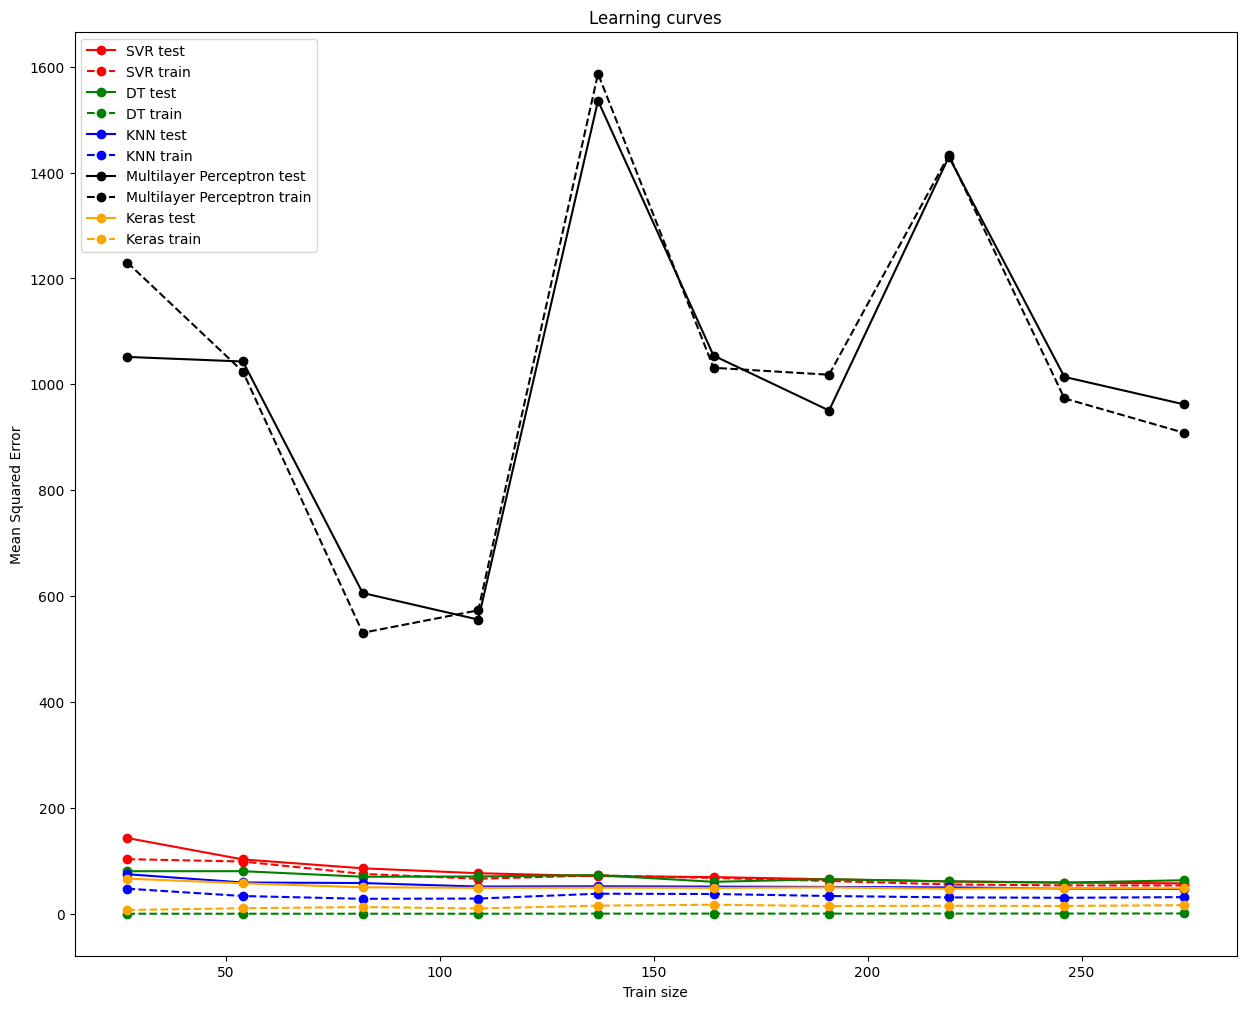

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 27, number of used features: 0
[LightGBM] [Info] Start training from score 38.514815
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

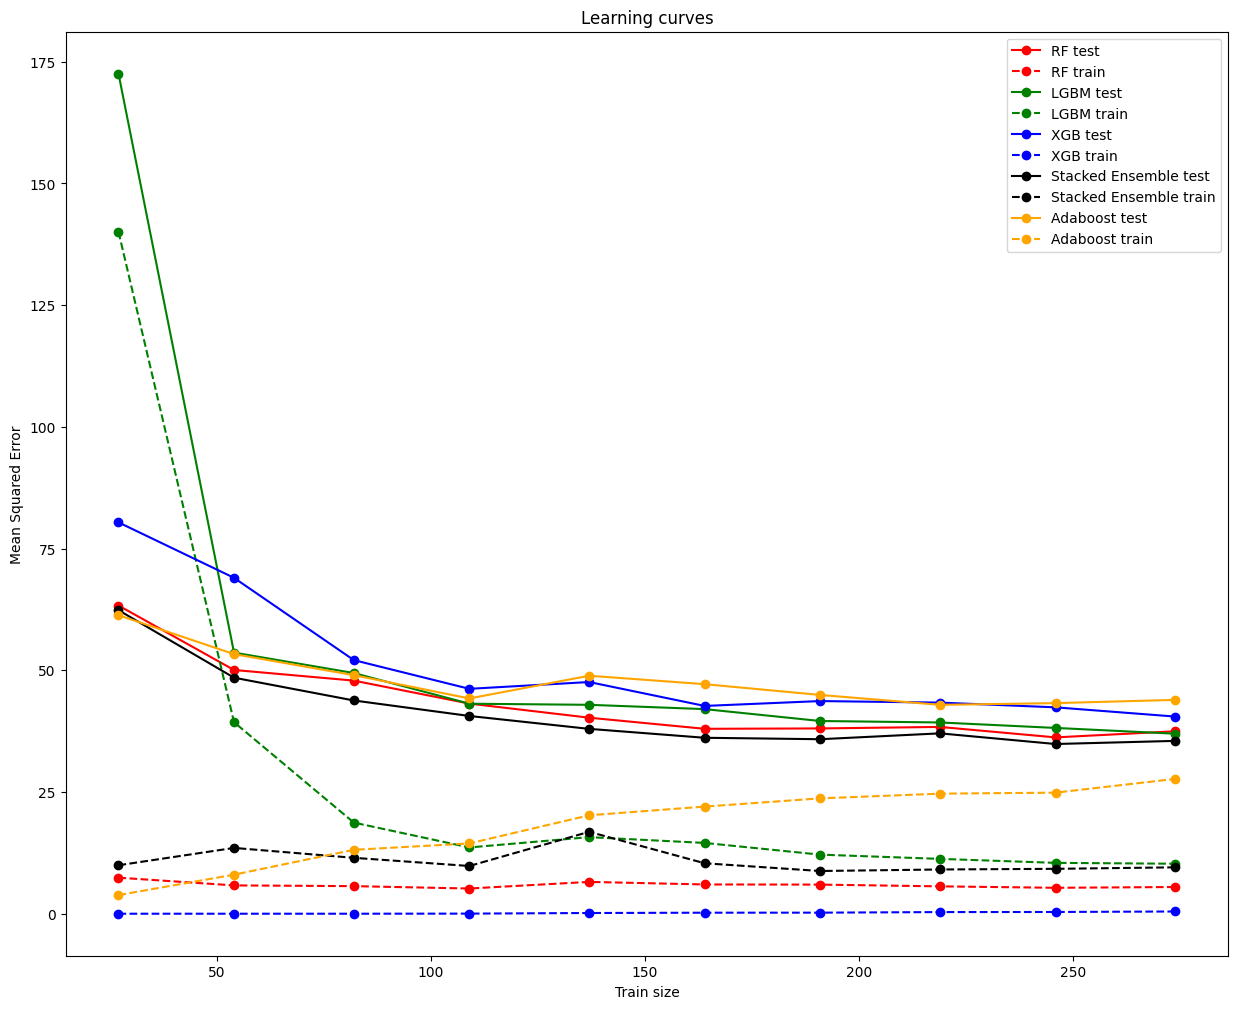

In [ ]:
from sklearn.svm import SVR
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import ShuffleSplit
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

train_size = 0.2 * len(X)

MLR = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', linear_model.LinearRegression()]])

lasso = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor',Lasso(alpha=0.5)]])

ridge = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', Ridge(alpha=0.5)]])

elasticnet = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', ElasticNet(alpha=0.25, l1_ratio=0.5)]])

MLP = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', MLPRegressor(hidden_layer_sizes=(150,150,1), max_iter = 1000,activation = 'relu', solver = 'adam')]])

kNN = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', KNeighborsRegressor(n_neighbors=5)]])

dt = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', DecisionTreeRegressor()]])

svr = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', SVR()]])

XGB = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', XGBRegressor(objective ='reg:squarederror')]])

RF = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', RandomForestRegressor()]])

LGBM = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', LGBMRegressor()]])

adaboost = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor',AdaBoostRegressor()]])

keras = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', KerasRegressor(build_fn=BuildModel,nb_epoch=500,epochs=500, batch_size=20,verbose=0)]])

stacked_ensemble = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', get_stacking()]])


# Visualize learning curves

plt.rcParams["figure.figsize"] = (15,12)
plt.figure()

train_sizes, train_scores_MLR, test_scores_MLR = learning_curve(
    MLR,
    X,
    y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_lasso, test_scores_lasso = learning_curve(
    lasso,
    X,
    y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_ridge, test_scores_ridge = learning_curve(
    ridge,
    X,
    y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_elasticnet, test_scores_elasticnet = learning_curve(
    elasticnet,
    X,
    y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)

plt.plot(train_sizes, -test_scores_MLR.mean(1), "o-", color="r", label="MLR test")
plt.plot(train_sizes, -train_scores_MLR.mean(1), "o--", color="r", label="MLR train")
plt.plot(train_sizes, -test_scores_lasso.mean(1), "o-", color="g", label="LASSO Regression test")
plt.plot(train_sizes, -train_scores_lasso.mean(1), "o--", color="g", label="LASSO Regression train")
plt.plot(train_sizes, -test_scores_ridge.mean(1), "o-", color="blue", label="Ridge Regression test")
plt.plot(train_sizes, -train_scores_ridge.mean(1), "o--", color="blue", label="Ridge Regression train")
plt.plot(train_sizes, -test_scores_elasticnet.mean(1), "o-", color="black", label="Elasticnet Regression test")
plt.plot(train_sizes, -train_scores_elasticnet.mean(1), "o--", color="black", label="Elasticnet Regression train")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title("Learning curves")
plt.legend(loc="best")
figure(figsize=(20, 15), dpi=80)
plt.show()

train_sizes, train_scores_svr, test_scores_svr = learning_curve(
    svr,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_dt, test_scores_dt = learning_curve(
    dt,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_kNN, test_scores_kNN = learning_curve(
    kNN,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_MLP, test_scores_MLP = learning_curve(
    MLP,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_keras, test_scores_keras = learning_curve(
    keras,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
plt.plot(train_sizes, -test_scores_svr.mean(1), "o-", color="red", label="SVR test")
plt.plot(train_sizes, -train_scores_svr.mean(1), "o--", color="red", label="SVR train")
plt.plot(train_sizes, -test_scores_dt.mean(1), "o-", color="green", label="DT test")
plt.plot(train_sizes, -train_scores_dt.mean(1), "o--", color="green", label="DT train")
plt.plot(train_sizes, -test_scores_kNN.mean(1), "o-", color="blue", label="KNN test")
plt.plot(train_sizes, -train_scores_kNN.mean(1), "o--", color="blue", label="KNN train")
plt.plot(train_sizes, -test_scores_MLP.mean(1), "o-", color="black", label="Multilayer Perceptron test")
plt.plot(train_sizes, -train_scores_MLP.mean(1), "o--", color="black", label="Multilayer Perceptron train")
plt.plot(train_sizes, -test_scores_keras.mean(1), "o-", color="orange", label="Keras test")
plt.plot(train_sizes, -train_scores_keras.mean(1), "o--", color="orange", label="Keras train")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title("Learning curves")
plt.legend(loc="best")

plt.show()


train_sizes, train_scores_RF, test_scores_RF = learning_curve(
    RF,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_XGB, test_scores_XGB = learning_curve(
    XGB,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_LGBM, test_scores_LGBM = learning_curve(
    LGBM,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_adaboost, test_scores_adaboost = learning_curve(
    adaboost,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_stacked_ensemble, test_scores_stacked_ensemble = learning_curve(
    stacked_ensemble,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
plt.plot(train_sizes, -test_scores_RF.mean(1), "o-", color="red", label="RF test")
plt.plot(train_sizes, -train_scores_RF.mean(1), "o--", color="red", label="RF train")
plt.plot(train_sizes, -test_scores_LGBM.mean(1), "o-", color="green", label="LGBM test")
plt.plot(train_sizes, -train_scores_LGBM.mean(1), "o--", color="green", label="LGBM train")
plt.plot(train_sizes, -test_scores_XGB.mean(1), "o-", color="blue", label="XGB test")
plt.plot(train_sizes, -train_scores_XGB.mean(1), "o--", color="blue", label="XGB train")
plt.plot(train_sizes, -test_scores_stacked_ensemble.mean(1), "o-", color="black", label="Stacked Ensemble test")
plt.plot(train_sizes, -train_scores_stacked_ensemble.mean(1), "o--", color="black", label="Stacked Ensemble train")
plt.plot(train_sizes, -test_scores_adaboost.mean(1), "o-", color="orange", label="Adaboost test")
plt.plot(train_sizes, -train_scores_adaboost.mean(1), "o--", color="orange", label="Adaboost train")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title("Learning curves")
plt.legend(loc="best")

plt.show()

#**Winner Winner, Chicken Dinner**

Base learner regressor performance results on the holdout sample are as follows:

|**Regressor** |    MSE    |       MAE      |    $R^2$    |Worst Prediction Error % |
|:----------------------|:------------:|:--------------:|:-------------:|:-------------:|
|kNN | 48.98 | 4.93 | 0.63 | 478 |
|Ridge Regression | 52.48 | 5.14 | 0.60 | 437 |
|Multiple Linear Regression (MLR) | 52.52 | 5.14 | 0.60 | 437 |
|SVM | 54.76 | 5.30 | 0.58 | 448 |
|Decision Tree | 54.78 | 5.84 | 0.71 | 167 |
|ElasticNet Regression | 57.02 | 5.40 | 0.57 | 421 |
|Multilayer Perceptron | 64.90 | 5.93 |0.51 | 355 |
|Lasso Regression | 93.07 | 7.07 |0.29 | 414 |



Ensemble and deep learner regressor performance results on the holdout sample are as follows:

|**Regressor** |    MSE    |       MAE      |    $R^2$    |  Worst Prediction Error % |
|:----------------------|:------------:|:--------------:|:-------------:|:-------------:|
|Stacked Ensemble | 34.83 | 4.27 | 0.73 | 383 |
|XGBoost | 36.16 | 4.33 | 0.72 | 359 |
|Random Forest | 37.28| 4.50 | 0.72 | 356 |
|Adaboost | 44.63 | 5.02 | 0.66 | 398 |
|Keras DL | 72.72 | 6.17 |0.45 | 418 |



The one poor prediction generates very high worst-case instance production erors. It points to the need for better analysis of performance of the varous models using cross validation is needed before one can really pick a winner. In the interest of novelty, we will pick the Keras model and analyze its performance further.

## Deep learning architectures

Deep Learning Architectures
Deep learning architectures are a class of artificial neural networks that are capable of learning hierarchical representations of data by stacking multiple layers of non-linear transformations. These architectures have proven to be highly effective in various domains, including computer vision, natural language processing, and time series forecasting.

### Feedforward Neural Networks
Feedforward neural networks, also known as multi-layer perceptrons (MLPs), are the most basic type of deep learning architecture. They consist of an input layer, one or more hidden layers, and an output layer. Each layer is composed of interconnected nodes, or neurons, that receive input from the previous layer, perform a non-linear transformation, and pass the result to the next layer.

The feedforward nature of these networks means that the information flows in a single direction, from the input layer through the hidden layers to the output layer, without any feedback connections. Feedforward networks are widely used for tasks such as image classification, regression, and pattern recognition.

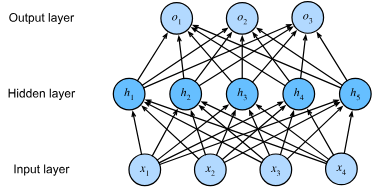

Source: Dive into Deep Learning

### Convolutional Neural Networks (CNNs)
Convolutional neural networks (CNNs) are a type of deep learning architecture specifically designed for processing grid-like data, such as images or spatial data. They are particularly effective for tasks like image classification, object detection, and semantic segmentation.

CNNs introduce the concept of convolutional layers, which apply learnable filters (kernels) to the input data, capturing local patterns and spatial relationships. These layers are followed by pooling layers, which downsample the feature maps and provide translation invariance. CNNs also typically include fully connected layers at the end, similar to those in feedforward networks, for classification or regression tasks.

The hierarchical structure of CNNs, with alternating convolutional and pooling layers, allows them to learn increasingly complex and abstract representations of the input data, making them well-suited for tasks involving visual data.

### Long Short-Term Memory (LSTM) Networks
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) architecture designed to handle sequential data, such as text, speech, or time series data. Unlike feedforward networks, LSTMs have feedback connections, allowing them to maintain an internal state and model sequential dependencies.

LSTMs address the vanishing gradient problem, a common issue in traditional RNNs, by introducing gated units that regulate the flow of information through the network. These gates control what information is added to or removed from the cell state, enabling LSTMs to selectively remember and forget information over long sequences.

LSTMs are widely used in various natural language processing tasks, such as language modeling, machine translation, and sentiment analysis, as well as in time series forecasting and anomaly detection.

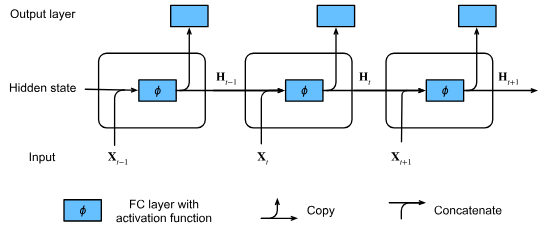

An RNN with a hidden state.

Source: Dive into Deep Learning

#**Keras Model Investigated**

In [ ]:
# Cross Validation of Keras Model with Learning Curve
# Adapting code from here: https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
# This takes quite a long time to execute, even on Cola Pro
seed = 12345
np.random.seed(seed)
# define 10-fold cross validation test harness
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
MSE_scores = []
Worst_cases = []
for train, test in kfold.split(X, y):
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = y.iloc[train]
    y_test = y.iloc[test]
    stdsc3 = StandardScaler()
    X_train_std = stdsc3.fit_transform(X_train)
    X_test_std = stdsc3.transform(X_test)
    stdsc4 = StandardScaler()
    y_train_std = stdsc4.fit_transform(y_train)
    y_test_std = stdsc4.transform(y_test)
    # create model
    model = Sequential()
    model.add(Dense(50, input_dim=7, activation='relu')) # Add comment
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='linear'))
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])
    # Fit the model
    model.fit(X_train_std, np.ravel(y_train_std), epochs=500, batch_size=10, verbose=0)
    # evaluate the model
    y_pred_std = model.predict(X_test_std)
    y_pred_std = pd.DataFrame(y_pred_std)
    y_pred = stdsc4.inverse_transform(y_pred_std)
    # Performance
    mse_ = mean_squared_error(y_pred, y_test)
    MSE_scores.append(mse_)
    y_pred = pd.DataFrame(y_pred)
    y_test = pd.DataFrame(y_test)
    results = pd.concat([y_pred, y_test.set_index(y_pred.index)], axis=1)
    results.columns=['Pred','Act']
    results['error'] = (results.Pred - results.Act)/results.Act
    error_ = 100*np.max(results.error)
    Worst_cases.append(error_)
    print('Fold: ',kfold, 'MSE: ',mse_, 'worst case instance:',error_)
print('SUMMARY:\nAverage MSE: ',np.mean(MSE_scores), 'Average worst case instance error %:',np.mean(Worst_cases))
print('SUMMARY:\nStd dev. of MSE: ',np.std(MSE_scores), 'Std dev. of worst case instance error %:',np.std(Worst_cases))

3/3 [==============================] - 0s 3ms/step
Fold:  KFold(n_splits=5, random_state=12345, shuffle=True) MSE:  55.20821516590782 worst case instance: 85.64580561040522
3/3 [==============================] - 0s 3ms/step
Fold:  KFold(n_splits=5, random_state=12345, shuffle=True) MSE:  93.98235083864779 worst case instance: 399.8291919105931
3/3 [==============================] - 0s 4ms/step
Fold:  KFold(n_splits=5, random_state=12345, shuffle=True) MSE:  61.971451730802706 worst case instance: 67.99784981630704


3/3 [==============================] - 0s 4ms/step
Fold:  KFold(n_splits=5, random_state=12345, shuffle=True) MSE:  77.10845333554208 worst case instance: 82.0888831967213


3/3 [==============================] - 0s 4ms/step
Fold:  KFold(n_splits=5, random_state=12345, shuffle=True) MSE:  68.6319067647728 worst case instance: 154.32131971631733
SUMMARY:
Average MSE:  71.38047556713464 Average worst case instance error %: 157.9766100500688
SUMMARY:
Std dev. of MSE:  13.425951449364591 Std dev. of worst case instance error %: 124.57359443404334


# Comparison of the performance of models

Performance Delta of Base Learner vs Ensemble:
MLR: -2.6552510864728447
Ridge: -2.286941783313978
RF: 4.247275125786473
XGB: 0.8754473340345612

Relative Performance of Boosting vs DL vs AutoML:
Boosting MSE: 1771.9312298384264


<ipython-input-26-350e3c6d679a>:31: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  dl_model = KerasRegressor(build_fn=BuildModel, nb_epoch=500, epochs=500, batch_size=20, verbose=0)


Deep Learning MSE: 1774.9203887844526
AutoML MSE: 1773.7962605917362


<ipython-input-26-350e3c6d679a>:56: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_std, y_train_std)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_rfe.py:299: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_rfe.py:326: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X[:, features], y, **fit_params)
<ipython-input-26-350e3c6d679a>:74: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as

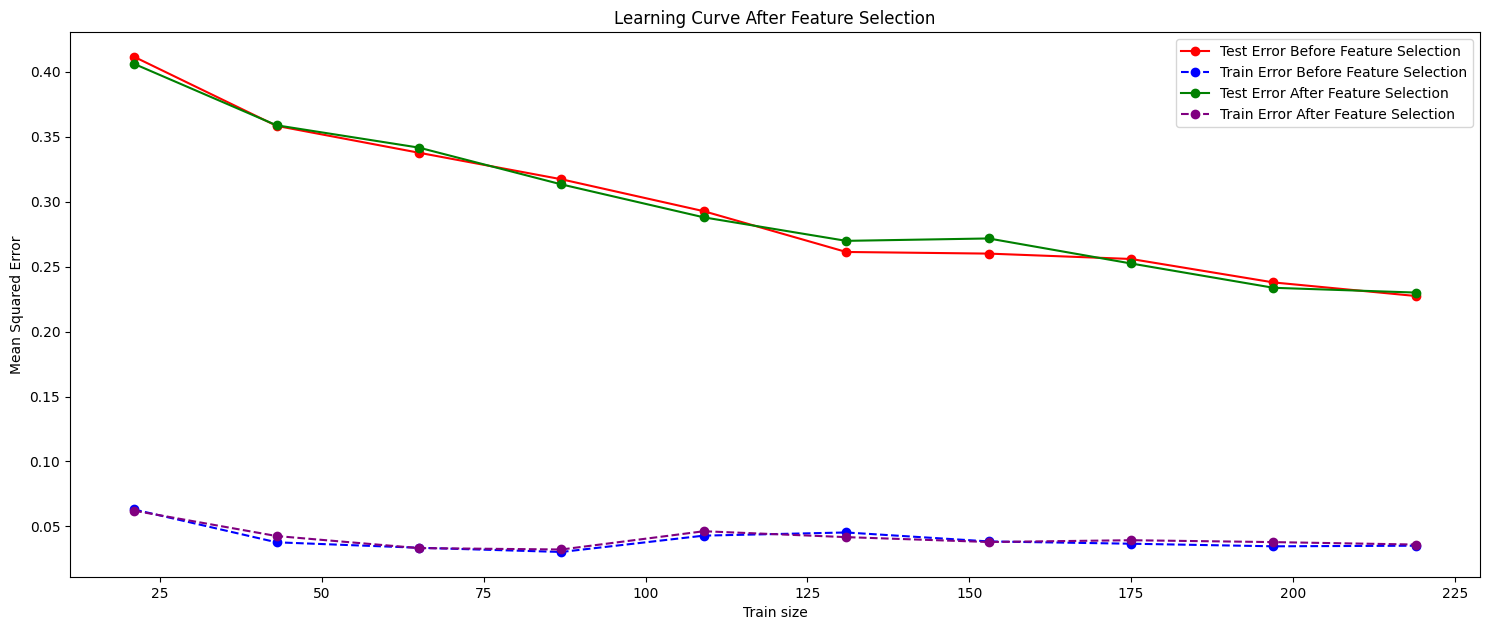

In [ ]:
from sklearn.feature_selection import RFE

# 1. Performance Delta of Base Learner vs Ensemble
base_learners = {
    'MLR': linear_model.LinearRegression(),
    'Ridge': Ridge(alpha=0.5),
    'RF': RandomForestRegressor(),
    'XGB': XGBRegressor(objective='reg:squarederror')
}

ensemble = get_stacking()

performance_delta = {}
for name, base_learner in base_learners.items():
    base_learner.fit(X_train_std, np.ravel(y_train_std))
    base_learner_pred = base_learner.predict(X_test_std)
    base_learner_error = mean_squared_error(y_test, base_learner_pred)

    ensemble.fit(X_train_std, np.ravel(y_train_std))
    ensemble_pred = ensemble.predict(X_test_std)
    ensemble_error = mean_squared_error(y_test, ensemble_pred)

    performance_delta[name] = ensemble_error - base_learner_error

print("Performance Delta of Base Learner vs Ensemble:")
for name, delta in performance_delta.items():
    print(f"{name}: {delta}")

# 2. Relative Performance of Boosting vs DL vs AutoML
boosting_model = AdaBoostRegressor()
dl_model = KerasRegressor(build_fn=BuildModel, nb_epoch=500, epochs=500, batch_size=20, verbose=0)
automl_model = get_stacking()

models = {
    'Boosting': boosting_model,
    'Deep Learning': dl_model,
    'AutoML': automl_model
}

print("\nRelative Performance of Boosting vs DL vs AutoML:")
for name, model in models.items():
    model.fit(X_train_std, np.ravel(y_train_std))
    model_pred = model.predict(X_test_std)
    model_error = mean_squared_error(y_test, model_pred)
    print(f"{name} MSE: {model_error}")

# 3. Delta from Feature Selection (Bias-Variance) using Learning Curves
# Plot learning curves before and after feature selection
# Assume you have already performed feature selection and obtained X_train_selected, X_test_selected

plt.figure(figsize=(15, 12))

model = RandomForestRegressor()

# Fit the model
model.fit(X_train_std, y_train_std)

# Get importance
importance = model.feature_importances_

# Summarize feature importance
plt.barh(col_names, importance)

# Initialize RFE with RandomForestRegressor
rfe = RFE(estimator=model, n_features_to_select=6)  # Choose the number of features you want to select

# Fit RFE to the training data
rfe.fit(X_train_std, y_train_std)

# Get selected features
selected_features = rfe.support_

# Plot learning curve before feature selection
plt.subplot(2, 1, 1)
train_sizes, train_scores_before, test_scores_before = learning_curve(
    model, X_train_std, np.ravel(y_train_std),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error", cv=3)
plt.plot(train_sizes, -test_scores_before.mean(1), "o-", color="r", label="Test Error Before Feature Selection")
plt.plot(train_sizes, -train_scores_before.mean(1), "o--", color="b", label="Train Error Before Feature Selection")
# plt.xlabel("Train size")
# plt.ylabel("Mean Squared Error")
# plt.title("Learning Curve Before Feature Selection")
# plt.legend(loc="best")

# Assuming you have already obtained the selected features using RFE
selected_features = rfe.support_
selected_features_indices = [i for i, selected in enumerate(selected_features) if selected]

# Subset the original feature set using the selected features indices
X_train_selected = X_train_std[:, selected_features_indices]

# Plot learning curve after feature selection
# plt.subplot(2, 1, 2)
train_sizes, train_scores_after, test_scores_after = learning_curve(
    model, X_train_selected, np.ravel(y_train_std),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error", cv=3)
plt.plot(train_sizes, -test_scores_after.mean(1), "o-", color="g", label="Test Error After Feature Selection")
plt.plot(train_sizes, -train_scores_after.mean(1), "o--", color="purple", label="Train Error After Feature Selection")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve After Feature Selection")
plt.legend(loc="best")

plt.tight_layout()
plt.show()


#**Conclusion**
* A holdout sample validation approach is risky with this dataset. That said, the ensembles, and the stacked ensemble, in particular, seem to outperform the base learners. The worst case instance prediction errors are horrendous: there is one test instance that is evidently hard to predict.
* A cross-validated deep learning model yields the best performance results of the notebook, with an MSE of around 20 and a worst case error in the 115% range.
* Overall, this solution probably does not make the cut. It's likely not suitable even as a decision aid. Additional modeling, with more instances, and more predictors (including, for example, property characteristics (beds, baths, amenities, quality of the finishes, etc.), and other neighborhood amenities)) seems to be a natural next step.
